<H1>Multivariate prediction of difference in flows</h1>

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam


<h2>Importing data</h2>

In [57]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]
df=pd.read_excel(directory_list[2])     #This contains the flow.bc values
df.index=pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')
y_val = df[-366:]
df = df[1:-365]

df_roc=pd.read_excel(directory_list[3])     #This contains the rate of change values
X_val = df_roc[-366:]    #validation dataset
df_roc = df_roc[1:-365]
df_roc.index=pd.to_datetime(df_roc['Date'],format='%d.%m.%Y %H:%M:%S')
X_val.columns


Index(['Date', 'ANDER/flow.bc', 'MENDE/flow.bc', 'OPLAD/flow.bc',
       'NEUBR/flow.bc', 'RUHRW/flow.bc', 'SCHER/flow.bc', 'ANDER_BONN/flow',
       'MENDE_MSIEG/flow', 'BONN_MSIEG/flow', 'MSIEG_KOELN/flow',
       'KOELN_MWUPP/flow', 'OPLAD_MWUPP/flow', 'NEUBR_MERFT/flow',
       'MWUPP_MERFT/flow', 'MERFT_DUESS/flow', 'DUESS_MRUHR/flow',
       'RUHRW_MRUHR/flow', 'MRUHR_DUISB/flow', 'DUISB_WESEL/flow',
       'WESEL_MLIPP/flow', 'SCHER_MLIPP/flow', 'MLIPP_REES/flow',
       'REES_EMMER/flow', 'ANDER/flow', 'BONN/flow', 'BONN/flow.bc',
       'BONN/flow.obs', 'MENDE/flow', 'MSIEG/flow', 'KOELN/flow',
       'KOELN/flow.bc', 'KOELN/flow.obs', 'OPLAD/flow', 'MWUPP/flow',
       'NEUBR/flow', 'MERFT/flow', 'DUESS/flow', 'DUESS/flow.bc',
       'DUESS/flow.obs', 'RUHRW/flow', 'MRUHR/flow', 'DUISB/flow',
       'DUISB/flow.bc', 'DUISB/flow.obs', 'WESEL/flow', 'WESEL/flow.bc',
       'WESEL/flow.obs', 'SCHER/flow', 'MLIPP/flow', 'REES/flow',
       'REES/flow.bc', 'REES/flow.obs', 'EMMER/

<h3>Input data</h3>

In [58]:
features_for_input=['Rate of change ANDER/flow.bc',
              'Rate of change MENDE/flow.bc',
              'Rate of change OPLAD/flow.bc',
              'Rate of change NEUBR/flow.bc',
              'Rate of change RUHRW/flow.bc',
              'Rate of change SCHER/flow.bc',
              'Rate of change BONN/flow.obs',
              'Rate of change KOELN/flow.obs',
              'Rate of change DUESS/flow.obs',
              'Rate of change DUISB/flow.obs',
              'Rate of change WESEL/flow.obs',
              'Rate of change REES/flow.obs',
              'Rate of change EMMER/flow.obs']

df_input=df_roc[features_for_input]
X_val= X_val[features_for_input]
X_val

,Rate of change ANDER/flow.bc,Rate of change MENDE/flow.bc,Rate of change OPLAD/flow.bc,Rate of change NEUBR/flow.bc,Rate of change RUHRW/flow.bc,Rate of change SCHER/flow.bc,Rate of change BONN/flow.obs,Rate of change KOELN/flow.obs,Rate of change DUESS/flow.obs,Rate of change DUISB/flow.obs,Rate of change WESEL/flow.obs,Rate of change REES/flow.obs,Rate of change EMMER/flow.obs
3287,-40.0,-3.799999,-5.100000,0.09,-9.700005,2.300001,-30.0,-30.0,-30.0,-40.0,-10.0,-10.0,10.0
3288,-50.0,-4.200001,-1.300000,-0.56,-7.599998,-3.400002,-60.0,-60.0,-60.0,-50.0,-40.0,-40.0,-30.0
3289,-40.0,-2.399998,-4.599999,-0.08,-9.000000,0.000000,-40.0,-50.0,-50.0,-60.0,-50.0,-60.0,-60.0
3290,0.0,-3.400002,-0.600000,-0.32,-6.099998,-0.500000,0.0,-10.0,-30.0,-50.0,-60.0,-60.0,-60.0
3291,-60.0,-3.099998,0.100000,0.10,-4.600002,-1.900000,-60.0,-60.0,-20.0,-20.0,-40.0,-40.0,-50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,-20.0,0.200000,0.059999,-0.40,11.000000,0.299999,-30.0,-50.0,-50.0,-50.0,-50.0,-60.0,-70.0
3649,-50.0,2.400000,-0.110000,-0.23,-1.000000,0.100000,-40.0,-30.0,-20.0,-40.0,-40.0,-40.0,-50.0
3650,0.0,-1.599999,0.850000,0.27,-6.000000,0.400000,-10.0,-20.0,-40.0,-30.0,-30.0,-30.0,-40.0
3651,-30.0,0.800000,2.500000,1.11,25.000000,0.799999,-20.0,-20.0,-10.0,-10.0,-20.0,-30.0,-40.0


<h2>Preprocessing data </h2>

<h3>Adding periodicity for date</h3>

<h3>Creating the label dataframe</h3>

In [59]:
output_attributes=['BONN/flow.bc',
                    'KOELN/flow.bc',
                    'DUESS/flow.bc',
                    'DUISB/flow.bc',
                    'WESEL/flow.bc',
                    'REES/flow.bc',
                    'EMMER/flow.bc']
output_size= len(output_attributes)
df_output=df[output_attributes]
y_val=y_val[output_attributes]

<h2>Splitting data into test, validation and train with window size</h2>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.33, random_state=42)


<h3> Scaling the input and target data</h3>

In [61]:
scaler_x=StandardScaler()
scaler_y=StandardScaler()

X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test))
X_val_scaled = pd.DataFrame(scaler_x.transform(X_val))

y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train))
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test))
y_val_scaled = pd.DataFrame(scaler_y.transform(y_val))

<h1>Sklearn Multioutput regressor</h1>

In [62]:
base_regressor = GradientBoostingRegressor()
#base_regressor = LinearRegression()
#base_regressor = DecisionTreeRegressor()
#base_regressor = RandomForestRegressor()
#base_regressor = SVR()
multioutput_regressor = MultiOutputRegressor(base_regressor)

<h2>Fitting the model</h2>

In [63]:
multioutput_regressor.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

<h2>Predicting and rescaling back</h2>

In [64]:
predictions_scaled = multioutput_regressor.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

predictions_regressor_df=pd.DataFrame(predictions)  #Converting back to dataframes to easily calculate Evaluation metrics 
predictions_regressor_df.columns=df_output.columns  #Giving back the column names
predictions_regressor_df.index= df_output.index[-len(y_test):]  #Giving back the column index
predictions_regressor_df


,BONN/flow.bc,KOELN/flow.bc,DUESS/flow.bc,DUISB/flow.bc,WESEL/flow.bc,REES/flow.bc,EMMER/flow.bc
Date,,,,,,,
2001-10-12,-6.629938,6.471829,6.673599,17.133825,5.501190,8.369863,5.441099
2001-10-13,5.111431,18.143428,19.219630,28.892155,21.381323,18.189080,13.335427
2001-10-14,29.794027,48.961421,56.522978,67.874101,73.800550,50.288217,27.809922
2001-10-15,10.617979,32.311763,48.231795,63.841855,69.532454,56.510512,29.941162
2001-10-16,5.111431,14.638633,19.094228,23.601953,17.271638,14.671717,10.809201
...,...,...,...,...,...,...,...
2004-09-26,-7.108753,8.935150,17.152000,36.756010,15.117878,0.966912,0.246075
2004-09-27,-27.181118,-17.703788,-22.735774,-8.273639,-6.746911,-2.763333,1.243954
2004-09-28,22.062031,43.460201,52.338976,55.159854,48.028619,35.317937,24.839598


<h2>Evaluation metrics</h2>

In [14]:
mae_regressor = mean_absolute_error(y_test, predictions)
mse_regressor = mean_squared_error(y_test, predictions)
mae_regressor, mse_regressor

(12.050722015489708, 307.26235512671076)

<h2>Evaluation metrics for each and every label</h2>

In [15]:
mae_dict = {}
mse_dict = {}

for column in predictions_regressor_df.columns:
    mae = mean_absolute_error(y_test[column], predictions_regressor_df[column])
    mse = mean_squared_error(y_test[column], predictions_regressor_df[column])
    mae_dict[column] = mae
    mse_dict[column] = mse
    
print("MAE for each column:")
for column, mae in mae_dict.items():
    print(f"{column}: {mae}")

print("\nMSE for each column:")
for column, mse in mse_dict.items():
    print(f"{column}: {mse}")

MAE for each column:
BONN/flow.bc: 14.714900194105004
KOELN/flow.bc: 8.828834990922573
DUESS/flow.bc: 10.545813516486035
DUISB/flow.bc: 13.401831266271053
WESEL/flow.bc: 11.90733812591839
REES/flow.bc: 14.028341153627903
EMMER/flow.bc: 10.927994861096995

MSE for each column:
BONN/flow.bc: 384.96545749177693
KOELN/flow.bc: 171.09283774914195
DUESS/flow.bc: 217.704514057877
DUISB/flow.bc: 451.5444607982106
WESEL/flow.bc: 307.9937868548389
REES/flow.bc: 375.7453507294012
EMMER/flow.bc: 241.7900782057287


<h2>Output visualization</h2>

In [16]:
predictions_regressor_df.columns=['predicted_'+col for col in predictions_regressor_df.columns]

presentation_regressor_df= pd.concat([predictions_regressor_df,y_test], axis=1)

In [ ]:
y_test_array = np.array(y_test)
for i in range(len(df_output)-1):
    data= {
        'Date': df_output.index[-len(predictions):],
        'Predictions': predictions[:, i],
        'Simulated MBC': y_test_array[:, i]
        }

    df_plot = pd.DataFrame(data)

    fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='Predictions vs Actual for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.show()
    #filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_regressor_'+df_output.columns[i][:3]+'.html'
    #fig.write_html(filepath)


<h2>Validation</h2>

In [66]:
predictions_scaled_val = multioutput_regressor.predict(X_val_scaled)
predictions_val = scaler_y.inverse_transform(predictions_scaled_val)

predictions_regressor_df_val=pd.DataFrame(predictions_val)  #Converting back to dataframes to easily calculate Evaluation metrics 
predictions_regressor_df_val.columns=df_output.columns  #Giving back the column names
predictions_regressor_df_val.index= df_output.index[-len(y_val):]  #Giving back the column index
predictions_regressor_df_val

,BONN/flow.bc,KOELN/flow.bc,DUESS/flow.bc,DUISB/flow.bc,WESEL/flow.bc,REES/flow.bc,EMMER/flow.bc
Date,,,,,,,
2003-10-01,11.401777,12.580869,11.790731,23.794503,15.383215,9.075558,6.036825
2003-10-02,9.972992,18.393577,20.349660,29.628236,21.794473,17.265958,10.381044
2003-10-03,6.549456,16.383376,18.769248,25.574505,18.024892,16.249662,13.335427
2003-10-04,-2.564010,7.180265,6.069759,23.423466,10.759947,14.509742,9.406496
2003-10-05,9.434152,20.437630,21.245292,21.319133,11.037846,10.465041,10.667203
...,...,...,...,...,...,...,...
2004-09-26,-0.976741,14.214955,18.621225,27.814631,17.891129,15.751230,10.702113
2004-09-27,5.436069,19.526614,15.135849,20.947571,9.853980,11.110278,9.630401
2004-09-28,-5.426333,6.471829,8.067569,23.272741,14.609998,9.807201,6.746840


In [69]:
for i in range(0,len(df_output)):
    data= {
        'Date': y_val.index,
        'MIMO GBR': predictions_val[:, i],
        'DA': np.array(y_val)[:, i]
        }

    df_plot_val = pd.DataFrame(data)

    fig = px.scatter(df_plot_val, x='Date', y=['MIMO GBR', 'DA'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='MIMO GBR ROC input for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.update_layout(width=900, height=600,
                      legend={
                          'x': 0.75,  # x position
                          'y': 0.01,  # y position
                          'bgcolor': 'rgba(255, 255, 255, 0.5)',  # semi-transparent background
                          'bordercolor': 'Black',
                          'borderwidth': 1
                      })
    fig.show()
    # filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
    # fig.write_html(filepath)

IndexError: index 7 is out of bounds for axis 1 with size 7

<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [70]:
model = Sequential([
    Dense(200, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(200, activation='relu'),
    Dense(y_train_scaled.shape[1])  # Output layer
])

c:\Projects\WSV\kisters.water.rto_ipopt\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2> Compile the model </h2>

In [71]:
# sgd = SGD(learning_rate=0.00095, momentum=0.9)
# model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mean_absolute_error'])

#model.compile(optimizer=Adam(learning_rate=0.00009), loss='mean_squared_error',metrics=['mean_absolute_error'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=95, validation_split=0.3)

Epoch 1/95


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8918 - mean_absolute_error: 0.5564 - val_loss: 0.5298 - val_mean_absolute_error: 0.4413
Epoch 2/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5162 - mean_absolute_error: 0.4406 - val_loss: 0.2856 - val_mean_absolute_error: 0.3407
Epoch 3/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2707 - mean_absolute_error: 0.3413 - val_loss: 0.1788 - val_mean_absolute_error: 0.2785
Epoch 4/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1873 - mean_absolute_error: 0.2852 - val_loss: 0.1483 - val_mean_absolute_error: 0.2558
Epoch 5/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1634 - mean_absolute_error: 0.2689 - val_loss: 0.1344 - val_mean_absolute_error: 0.2461
Epoch 6/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1435 - mean_absolute_error: 0.2583 - val_loss: 0.1269 - val_mean_absolute_error: 0.2413
Epoch 7/95
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1451 - mean_absolute_error: 0.2622 - val_loss: 0.1199 - val_me

<h2>Model evaluation </h2>

In [73]:
predictions = model.predict(X_test_scaled)
predictions_rescaled = scaler_y.inverse_transform(predictions)
mae_FFNN=mean_absolute_error(y_test, predictions_rescaled)
mse_FFNN=mean_squared_error(y_test, predictions_rescaled)

predictions_FFNN_df=pd.DataFrame(predictions_rescaled)
predictions_FFNN_df.columns=y_test.columns

mae_FFNN, mse_FFNN

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(12.245934005008694, 310.5582455108753)

<h2>Plotting the validation loss and training loss</h2>

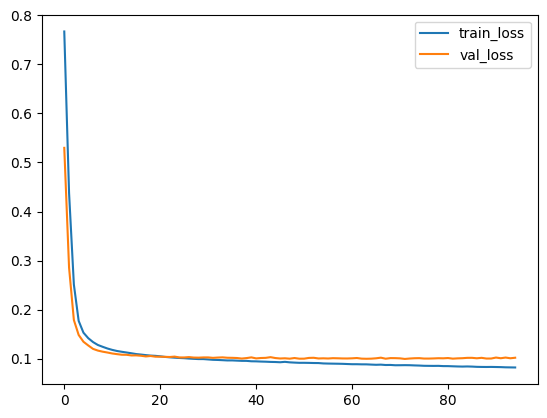

In [74]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

<h2>Evaluation metrics for each and every label</h2>

In [43]:
mae_dict_FFNN = {}
mse_dict_FFNN = {}
for column in predictions_FFNN_df.columns:
    mae = mean_absolute_error(y_test[column], predictions_FFNN_df[column])
    mse = mean_squared_error(y_test[column], predictions_FFNN_df[column])
    mae_dict_FFNN[column] = mae
    mse_dict_FFNN[column] = mse

print("MAE for each column:")
for column, mae in mae_dict_FFNN.items():
    print(f"{column}: {mae}")

print("\nMSE for each column:")
for column, mse in mse_dict_FFNN.items():
    print(f"{column}: {mse}")

MAE for each column:
BONN/flow.bc: 14.177721567124523
KOELN/flow.bc: 8.585383837251841
DUESS/flow.bc: 10.3256043024287
DUISB/flow.bc: 13.10040804020177
WESEL/flow.bc: 12.027337511628788
REES/flow.bc: 13.943406873567193
EMMER/flow.bc: 10.83635110432287

MSE for each column:
BONN/flow.bc: 351.4651224108409
KOELN/flow.bc: 140.83400647806562
DUESS/flow.bc: 213.06926059954412
DUISB/flow.bc: 495.84786699427167
WESEL/flow.bc: 318.2383948090696
REES/flow.bc: 342.00209247031086
EMMER/flow.bc: 239.34392949774485


<h2>Output visualization</h2>

In [ ]:
y_test_array = np.array(y_test)
for i in range(0,len(df_output)):
    data= {
        'Date': df_output.index[-len(predictions):],
        'Predictions': predictions_rescaled[:, i],
        'Simulated MBC': np.array(y_test)[:, i]
        }

    df_plot = pd.DataFrame(data)

    fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='Predictions vs Actual for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.show()
    # filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
    # fig.write_html(filepath)

<h2>Validation</h2>

In [75]:
predictions_val = model.predict(X_val_scaled)
predictions_rescaled_val = scaler_y.inverse_transform(predictions_val)

mae_FFNN_val=mean_absolute_error(y_val, predictions_rescaled_val)
mse_FFNN_val=mean_squared_error(y_val, predictions_rescaled_val)

predictions_FFNN_df_val=pd.DataFrame(predictions_rescaled_val)
predictions_FFNN_df_val.columns=y_val.columns

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [76]:
for i in range(0,len(df_output)):
    data= {
        'Date': y_val.index,
        'MIMO FFNN ROC': predictions_rescaled_val[:, i],
        'DA': np.array(y_val)[:, i]
        }

    df_plot_val = pd.DataFrame(data)

    fig = px.scatter(df_plot_val, x='Date', y=['MIMO FFNN ROC', 'DA'],
                    labels={'value': 'Mass balance correction (m³/s)'},
                    title='MIMO FFNN all ROC input for ' + df_output.columns[i],
                    color_discrete_sequence=['blue', 'orange'])
    fig.update_traces(marker={'size': 2},
                    mode='lines+markers')

    fig.update_layout(width=900, height=600,
                      legend={
                          'x': 0.75,  # x position
                          'y': 0.01,  # y position
                          'bgcolor': 'rgba(255, 255, 255, 0.5)',  # semi-transparent background
                          'bordercolor': 'Black',
                          'borderwidth': 1
                      })
    fig.show()
    # filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\MV_FFNN_'+df_output.columns[i][:3]+'.html'
    # fig.write_html(filepath)

IndexError: index 7 is out of bounds for axis 1 with size 7

<h1>LSTM model</h1>

In [682]:
scaler_x=MinMaxScaler(feature_range=(-1,1))
scaler_y=MinMaxScaler(feature_range=(-1,1))
X_train_scaled_np = scaler_x.fit_transform(X_train)
X_test_scaled_np  = scaler_x.transform(X_test)

y_train_scaled_np  = scaler_y.fit_transform(y_train)
y_test_scaled_np  = scaler_y.transform(y_test)

X_train_scaled_np.shape, y_train_scaled_np.shape, X_test_scaled_np.shape, y_test_scaled_np.shape
#X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled

((2446, 15), (2446, 7), (1206, 15), (1206, 7))

<h2>Model Initialization</h2>

In [687]:
model_lstm = Sequential([
    LSTM(200, input_shape=(X_train_scaled_np.shape[1], 1), activation='relu', return_sequences=True),
    LSTM(200, activation='relu', return_sequences=False),
    Dense(y_train_scaled_np.shape[1])  # Output layer
])

c:\Projects\WSV\kisters.water.rto_ipopt\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2>Model compilation</h2>

In [688]:
#model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.compile(loss= MeanSquaredError(),optimizer= Adam(learning_rate=0.001),metrics=[RootMeanSquaredError()])

<h2>Model fit</h2>

In [689]:
history_lstm = model_lstm.fit(X_train_scaled_np.reshape(X_train_scaled.shape[0], X_train_scaled_np.shape[1], 1),
                               y_train_scaled_np,
                               epochs=40,
                               validation_split=0.5)

Epoch 1/40


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0586 - root_mean_squared_error: 0.2387 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0087 - root_mean_squared_error: 0.0929 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0058 - r

<h2>Model Evaluation</h2>

In [690]:
predictions_lstm = model_lstm.predict(X_test_scaled_np.reshape(X_test_scaled_np.shape[0], X_test_scaled_np.shape[1], 1))
predictions_rescaled_lstm = scaler_y.inverse_transform(predictions_lstm)
mae_lstm = mean_absolute_error(y_test, predictions_rescaled_lstm)

mae_lstm=mean_absolute_error(y_test, predictions_rescaled_lstm)
mse_lstm=mean_squared_error(y_test, predictions_rescaled_lstm)
mae_lstm, mse_lstm

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


(15.506977426315727, 533.0224895397197)

<h2>Output visualisation</h2>

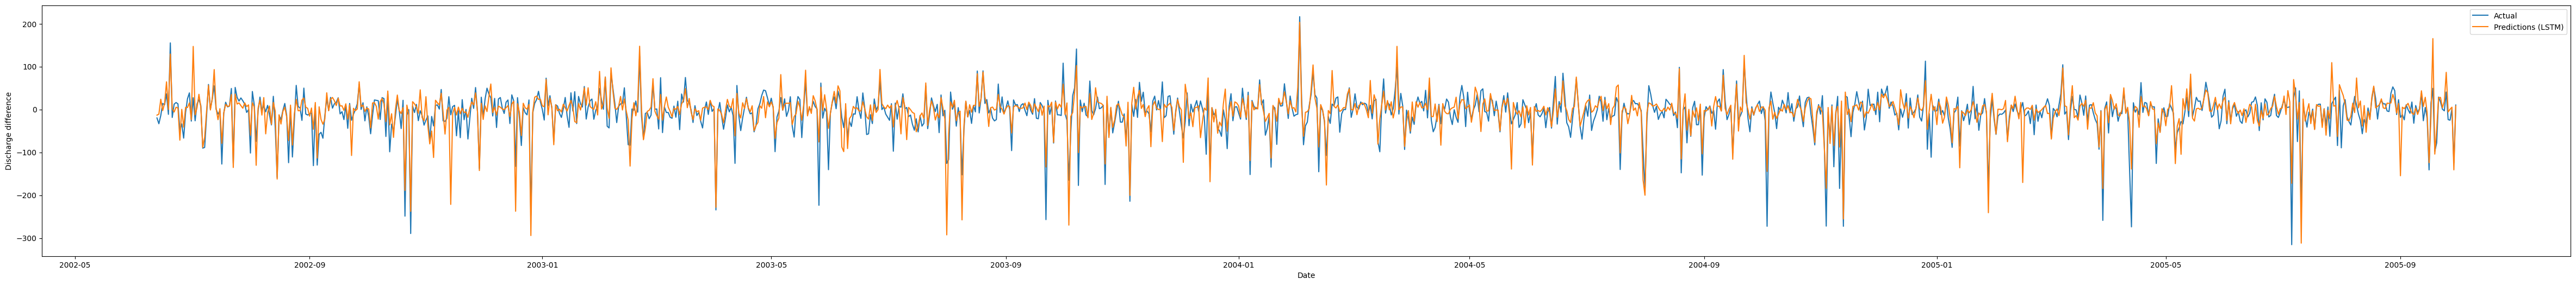

In [691]:
plt.figure(figsize=(60, 6))
plt.plot(df_output.index[-len(predictions_lstm):], np.array(y_test)[:, 0], label='Actual')
plt.plot(df_output.index[-len(predictions_lstm):], predictions_rescaled_lstm[:, 0], label='Predictions (LSTM)')
plt.xlabel('Date')
plt.ylabel('Discharge difference')
plt.legend()
plt.show()